## Training base CNN models and extracting features

First we begin by importing the important libraries used.

There are several weird errors shown in this notebook, these do not affect performance or outcomes, they are simply because the models were trained using a GPU, and the various CUDA toolkits, cuDNN, tensorflow have problems.

Regardless, they are only visual and everything was compiled and ran perfectly.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

2024-05-01 18:35:00.577224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 18:35:00.677774: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 18:35:01.087315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/shard746/miniconda3/envs/tefo/lib/
2024-05-01 18:35:01.087377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libn

First, we import our dataset, and assign it into training, validation and testing parts.

The dataset can be found here: https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k

Appropriate pre-processing on the images is done, which helps against over fitting and gives more realistic results.

In [2]:
# GPU availability checker
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            print("GPU:", gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")

# Importing and pre-processing dataset
img_size = 256
batch_size = 100

train_dir = 'rvf10k/train'
test_dir = 'rvf10k/valid'

train_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.1,
    brightness_range = (0.8, 1.2),
    zoom_range = 0.1,
    fill_mode = 'nearest',
    horizontal_flip = True,
    vertical_flip = True
)

test_gen = ImageDataGenerator(rescale = 1./255)

train_dataset = train_gen.flow_from_directory(
    train_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = True,
    subset = 'training'
)

val_dataset = train_gen.flow_from_directory(
    train_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = True,
    subset = 'validation'
)

test_dataset = test_gen.flow_from_directory(
    test_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False
)

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6300 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


2024-05-01 18:35:03.490885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 18:35:03.496032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 18:35:03.496232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


This tool we built below makes it easy to swap the different base models for training, as well as add or remove layers, change parameters, etc.

To change the base model, simply uncomment only 1 of the "train_model" options and run the cell.

Training takes a decent chunk of time, even on the RTX 3090 we used, so any changes have to be carefully considered beforehand.

In [3]:
def build_model(base_model_input):
    base_model = base_model_input(weights = 'imagenet', include_top = False, input_shape = (img_size, img_size, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs = base_model.input, outputs = predictions)
    
    model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

#train_model = build_model(InceptionV3)
#train_model = build_model(InceptionResNetV2)
train_model = build_model(Xception)

training = train_model.fit(train_dataset, epochs = 10, validation_data = val_dataset)

2024-05-01 18:35:09.646668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 18:35:09.647235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 18:35:09.647421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 18:35:09.647564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/10


2024-05-01 18:35:15.092255: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-05-01 18:35:16.234576: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 64s 922ms/step - loss: 0.4370 - accuracy: 0.7878 - val_loss: 0.6621 - val_accuracy: 0.7571
Epoch 2/10
63/63 [==============================] - 57s 903ms/step - loss: 0.1629 - accuracy: 0.9368 - val_loss: 1.5029 - val_accuracy: 0.6529
Epoch 3/10
63/63 [==============================] - 57s 900ms/step - loss: 0.0857 - accuracy: 0.9679 - val_loss: 0.2537 - val_accuracy: 0.9057
Epoch 4/10
63/63 [==============================] - 60s 937ms/step - loss: 0.0541 - accuracy: 0.9835 - val_loss: 0.1613 - val_accuracy: 0.9486
Epoch 5/10
63/63 [==============================] - 57s 895ms/step - loss: 0.0366 - accuracy: 0.9876 - val_loss: 0.1057 - val_accuracy: 0.9629
Epoch 6/10
63/63 [==============================] - 57s 889ms/step - loss: 0.0273 - accuracy: 0.9905 - val_loss: 0.0890 - val_accuracy: 0.9686
Epoch 7/10
63/63 [==============================] - 57s 890ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0740 - val_accuracy: 0.9743
Epoch 8/10

The cell below can be used to generate a plot for the training progression over the epochs.

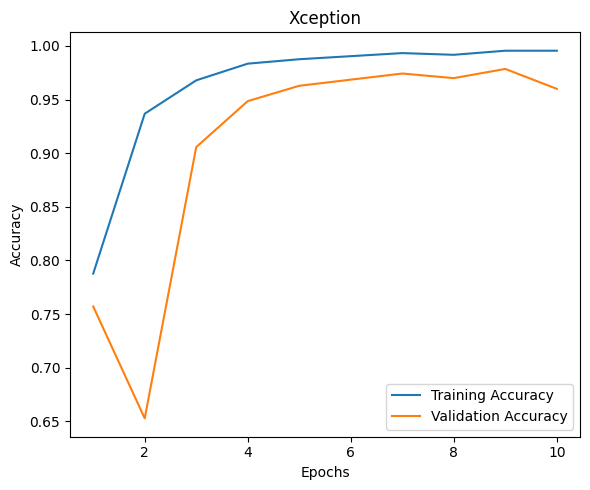

In [4]:
#title = "InceptionV3"
#title = "InceptionResNetV2"
title = "Xception"

acc = training.history['accuracy']
val_acc = training.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (6, 5))

plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title(f'{title}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Next, by uncommenting the appropriate "save_model" we can save the trained model to its proper directory.

This helps save a massive amount of time later for performance evaluation and further tweaks.

In [5]:
#save_model = "inceptionv3"
#save_model = "inceptionresnetv2"
save_model = "xception"

train_model.save(f'trained_models/{save_model}')

INFO:tensorflow:Assets written to: trained_models/xception/assets


INFO:tensorflow:Assets written to: trained_models/xception/assets


Optionally, the cell below can be used to load the already saved trained models.

In [6]:
#loading_model = "inceptionv3"
#loading_model = "inceptionresnetv2"
loading_model = "xception"

trained_model = load_model(f'trained_models/{loading_model}')

Next, we import the dataset once again, with shuffling turned off for proper feature extraction.

In [7]:
# Importing dataset without shuffling to extract features
img_size = 256
batch_size = 100

feature_train_dir = 'rvf10k/train'
feature_test_dir = 'rvf10k/valid'

feature_train_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.1,
    brightness_range = (0.8, 1.2),
    zoom_range = 0.1,
    fill_mode = 'nearest',
    horizontal_flip = True,
    vertical_flip = True
)

feature_test_gen = ImageDataGenerator(rescale = 1./255)

feature_train_dataset = feature_train_gen.flow_from_directory(
    train_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False,
    subset = 'training'
)

feature_val_dataset = feature_train_gen.flow_from_directory(
    train_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False,
    subset = 'validation'
)

feature_test_dataset = feature_test_gen.flow_from_directory(
    feature_test_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False
)

Found 6300 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


The trained CNNs are used without the last classification layer to extract the features from the images.

Features and labels for training, validation and testing are saved using numpy to their folder by uncommenting the appropriate "feature_dir".

In [8]:
# Extract features with base CNN model without last classification layer
feature_extractor = Model(inputs = trained_model.input, outputs = trained_model.layers[-1].output)

train_labels = feature_train_dataset.classes
val_labels = feature_val_dataset.classes
test_labels = feature_test_dataset.classes

train_features = feature_extractor.predict(feature_train_dataset)
val_features = feature_extractor.predict(feature_val_dataset)
test_features = feature_extractor.predict(feature_test_dataset)

#feature_dir = "inceptionv3"
#feature_dir = "inceptionresnetv2"
feature_dir = "xception"

np.save(f'extracted_features/{feature_dir}/train_features.npy', train_features)
np.save(f'extracted_features/{feature_dir}/val_features.npy', val_features)
np.save(f'extracted_features/{feature_dir}/test_features.npy', test_features)

np.save(f'extracted_features/{feature_dir}/train_labels.npy', train_labels)
np.save(f'extracted_features/{feature_dir}/val_labels.npy', val_labels)
np.save(f'extracted_features/{feature_dir}/test_labels.npy', test_labels)

30/30 [==============================] - 4s 145ms/step


Optionally, the already saved features and labels can be loaded in by uncommenting the appropriate "load_features_dir".

In [9]:
#load_features_dir = "inceptionv3"
#load_features_dir = "inceptionresnetv2"
load_features_dir = "xception"

train_features = np.load(f'extracted_features/{load_features_dir}/train_features.npy')
val_features = np.load(f'extracted_features/{load_features_dir}/val_features.npy')
test_features = np.load(f'extracted_features/{load_features_dir}/test_features.npy')

train_labels = np.load(f'extracted_features/{load_features_dir}/train_labels.npy')
val_labels = np.load(f'extracted_features/{load_features_dir}/val_labels.npy')
test_labels = np.load(f'extracted_features/{load_features_dir}/test_labels.npy')

Finally, the trained base CNNs are evaluated.

Here, we generate a classification report and a visual confusion matrix, which are later used to compare performance.

30/30 [==============================] - 5s 161ms/step
CNN (xception) results:

Accuracy:  0.9473333333333334
Classification Report:
               precision    recall  f1-score   support

        Fake     0.9985    0.8960    0.9445      1500
        Real     0.9057    0.9987    0.9499      1500

    accuracy                         0.9473      3000
   macro avg     0.9521    0.9473    0.9472      3000
weighted avg     0.9521    0.9473    0.9472      3000



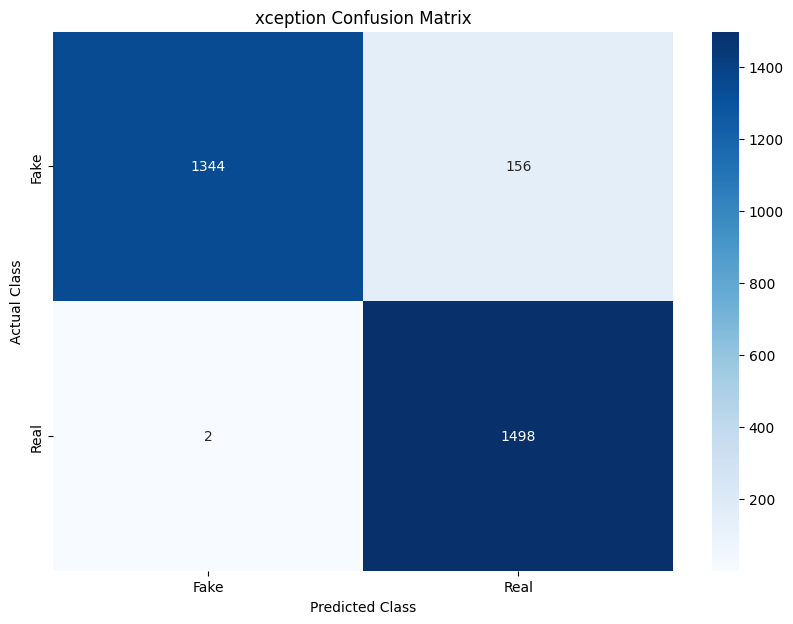

In [10]:
cnn_predictions = trained_model.predict(test_dataset)
predicted_labels = (cnn_predictions > 0.5).astype(int)
cnn_conf_mat= confusion_matrix(test_labels, predicted_labels)

print(f"CNN ({load_features_dir}) results:\n")
print("Accuracy: ", accuracy_score(test_labels, predicted_labels))
print("Classification Report:\n", classification_report(test_labels, predicted_labels, target_names = ['Fake', 'Real'], digits = 4))

plt.figure(figsize = (10, 7))
sns.heatmap(cnn_conf_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = ['Fake', 'Real'], yticklabels = ['Fake', 'Real'])
plt.title(f'{load_features_dir} Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()